#### Customer data

In [1]:
# Importing lots of stuff

import logging
import threading
import itertools
import pandas as pd  
import numpy as np 
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (BayesRidgeRegressor)                
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Merging data first

If you have already created the merge file BP_Data/full.csv skip the next two cells

In [2]:
'''
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./BP_DATA/BR-EH-1357_electricityData.csv', parse_dates=['dateTime'])
df_i['timestamp'] = pd.to_datetime(df_i['dateTime'], utc = True)
df_i['entity'] = 'Demand'
df_i['value'] = df_i['Real Demand (kW)']
df_i = df_i.drop(columns=['dateTime'])
df_i.set_index(['entity','timestamp'], inplace=True)




df_i.head(2)

for cnt in range(1,108):
    num = str(cnt).zfill(3)
    name = './BP_DATA/BR-EH-1357_automationData_' + str(cnt).zfill(3) + '.csv'
    print ('Merge', name)

    df_temp = pd.read_csv(name, parse_dates=['timestamp']).drop(columns=['siteName'])
    df_temp.rename(columns={'varName':'entity', 'varValue': 'value'}, inplace=True)
    df_temp.set_index(['entity','timestamp'], inplace=True)
    #df_temp
    
    
    
    #df_temp.index.rename('timestamp', inplace=True)
    df_i = df_i.merge(df_temp, on=['entity','timestamp','value'],how='outer')
    #print(df_i.shape)
    
#df_temp.head(10)
#df_i.head(10)
'''

"\n# Run on the good pump first \n# Get stuff in\ndf_i = pd.read_csv('./BP_DATA/BR-EH-1357_electricityData.csv', parse_dates=['dateTime'])\ndf_i['timestamp'] = pd.to_datetime(df_i['dateTime'], utc = True)\ndf_i['entity'] = 'Demand'\ndf_i['value'] = df_i['Real Demand (kW)']\ndf_i = df_i.drop(columns=['dateTime'])\ndf_i.set_index(['entity','timestamp'], inplace=True)\n\n\n\n\ndf_i.head(2)\n\nfor cnt in range(1,108):\n    num = str(cnt).zfill(3)\n    name = './BP_DATA/BR-EH-1357_automationData_' + str(cnt).zfill(3) + '.csv'\n    print ('Merge', name)\n\n    df_temp = pd.read_csv(name, parse_dates=['timestamp']).drop(columns=['siteName'])\n    df_temp.rename(columns={'varName':'entity', 'varValue': 'value'}, inplace=True)\n    df_temp.set_index(['entity','timestamp'], inplace=True)\n    #df_temp\n    \n    \n    \n    #df_temp.index.rename('timestamp', inplace=True)\n    df_i = df_i.merge(df_temp, on=['entity','timestamp','value'],how='outer')\n    #print(df_i.shape)\n    \n#df_temp.head(1

In [3]:
'''
df_i.to_csv('BP_DATA/full.csv')
df_i
'''

"\ndf_i.to_csv('BP_DATA/full.csv')\ndf_i\n"

In [4]:
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-10-13T12:00:55.287 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [5]:
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')

In [6]:
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
df_input['entity'] = 'Demand'
df_input = df_input.set_index(['entity','timestamp'])

In [7]:
df_input

TEMP_AIR  UMIDADE_REL          KW        KW2
entity timestamp                                                        
Demand 2019-09-15 00:00:00      18.7           80  690.480000  69.048000
       2019-09-15 01:00:00      18.2           83  685.440000  68.544000
       2019-09-15 02:00:00      18.2           83  656.880000  65.688000
       2019-09-15 03:00:00      18.2           83  655.200000  65.520000
       2019-09-15 04:00:00      18.3           82  660.240000  66.024000
...                              ...          ...         ...        ...
       2020-08-31 16:00:00      20.8           68  525.840027  52.584003
       2020-08-31 17:00:00      19.6           72  504.000000  50.400000
       2020-08-31 18:00:00      19.5           75  535.919983  53.591998
       2020-08-31 19:00:00      19.0           76  517.440003  51.744000
       2020-08-31 20:00:00      19.0           76  485.519990  48.551999

[8336 rows x 4 columns]

In [8]:
features=['TEMP_AIR']
targets=['KW']
listFeatTarg=['TEMP_AIR','UMIDADE_REL','KW']
predictions=['KW_pred']

In [9]:
#df_input[df_input['KW'] < 400]['KW'] = 400
#df_input.loc[df_input['KW'] < 400, 'KW'] = 400


# Scale
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, minmax_scale

scaled_features = RobustScaler().fit_transform(df_input[listFeatTarg])
df_scaled = pd.DataFrame(scaled_features, index=df_input.index, columns=listFeatTarg)

In [10]:
df_scaled

TEMP_AIR  UMIDADE_REL        KW
entity timestamp                                           
Demand 2019-09-15 00:00:00 -0.245614     0.291667  0.568345
       2019-09-15 01:00:00 -0.333333     0.416667  0.546763
       2019-09-15 02:00:00 -0.333333     0.416667  0.424460
       2019-09-15 03:00:00 -0.333333     0.416667  0.417266
       2019-09-15 04:00:00 -0.315789     0.375000  0.438849
...                              ...          ...       ...
       2020-08-31 16:00:00  0.122807    -0.208333 -0.136691
       2020-08-31 17:00:00 -0.087719    -0.041667 -0.230216
       2020-08-31 18:00:00 -0.105263     0.083333 -0.093525
       2020-08-31 19:00:00 -0.192982     0.125000 -0.172662
       2020-08-31 20:00:00 -0.192982     0.125000 -0.309353

[8336 rows x 3 columns]

In [70]:
from iotfunctions import anomaly
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.INFO)


gbmii = anomaly.GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=targets,
                     predictions=predictions)
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_i = gbmii.execute(df=df_scaled)

2020-10-12T18:30:38.612 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-10-12T18:30:38.627 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.KW.Demand']
2020-10-12T18:30:38.630 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.KW.Demand has been deleted from filesystem
2020-10-12T18:30:38.630 INFO iotfunctions.base.get_models_for_training predicting target KW
2020-10-12T18:30:38.631 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.KW.Demand does not exist in filesystem
2020-10-12T18:30:38.632 INFO iotfunctions.base.get_models_for_training load model None
2020-10-12T18:30:38.632 INFO iotfunctions.base.get_models_for_training training required: True  results: Training required because there is no existing model
2020-10-12T

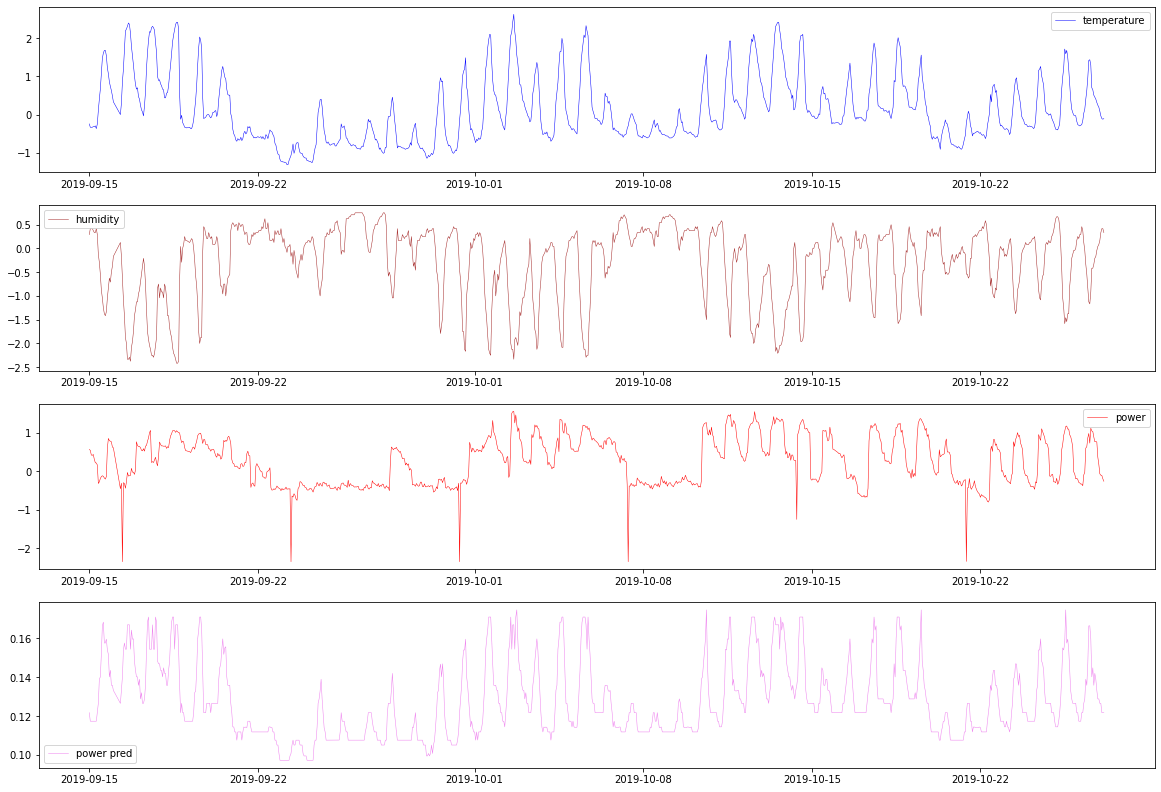

In [71]:
dfg = df_i.loc['Demand'][0:1000]
list

fig, ax = plt.subplots(4, 1,figsize=(20,14), squeeze=False)

ax[0,0].plot(dfg.index, dfg['TEMP_AIR'], lw=0.5, color='blue', label='temperature')
ax[1,0].plot(dfg.index, dfg['UMIDADE_REL'], lw=0.5, color='brown', label='humidity')
ax[2,0].plot(dfg.index, dfg['KW'], lw=0.5, color='red', label='power')
#ax[3].plot(dfg.index, dfg['accel_speed'], lw=0.5, color='green', label='speed')
ax[3,0].plot(dfg.index, dfg['KW_pred'], lw=0.5, color='violet', label='power pred')
[ax[i,0].legend() for i in range(4)]
#[ax[i].set_xticks([]) for i in range(4)]
#[ax[i].set_yticks([]) for i in range(5)]

In [11]:
df_input

TEMP_AIR  UMIDADE_REL          KW        KW2
entity timestamp                                                        
Demand 2019-09-15 00:00:00      18.7           80  690.480000  69.048000
       2019-09-15 01:00:00      18.2           83  685.440000  68.544000
       2019-09-15 02:00:00      18.2           83  656.880000  65.688000
       2019-09-15 03:00:00      18.2           83  655.200000  65.520000
       2019-09-15 04:00:00      18.3           82  660.240000  66.024000
...                              ...          ...         ...        ...
       2020-08-31 16:00:00      20.8           68  525.840027  52.584003
       2020-08-31 17:00:00      19.6           72  504.000000  50.400000
       2020-08-31 18:00:00      19.5           75  535.919983  53.591998
       2020-08-31 19:00:00      19.0           76  517.440003  51.744000
       2020-08-31 20:00:00      19.0           76  485.519990  48.551999

[8336 rows x 4 columns]

In [91]:
import pyflux as pf


model = pf.GPNARX(df_input[0:300]['KW'], ar=1, kernel=pf.OrnsteinUhlenbeck())

In [92]:
x = model.fit('MLE') #,nsims=30)

In [93]:
x.summary()

GPNARX(1)                                                                                                 
======================================================= ==================================================
Dependent Variable: TEMP_AIR                            Method: MLE                                       
Start Date: ('Demand', Timestamp('2019-09-15 01:00:00') Log Likelihood: -182.7614                         
End Date: ('Demand', Timestamp('2019-09-27 19:00:00'))  AIC: 371.5229                                     
Number of observations: 299                             BIC: 382.6242                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Noise Sigma^2                            0.2385                                                           
l                                    

In [57]:
kw_series = df_input.reset_index().set_index('timestamp')['KW']

In [58]:
import statsmodels.api as sm
sm.tsa.stattools.adfuller(kw_series)[1]

1.1515308779737342e-11

In [59]:
sm.tsa.stattools.kpss(kw_series)[1]

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


0.01

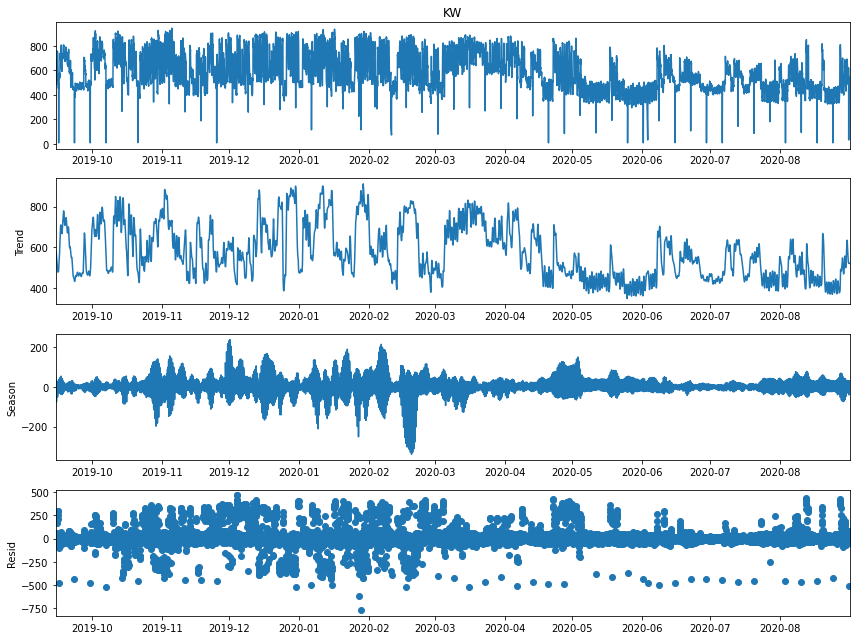

In [69]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

plt.rc('figure',figsize=(12,9))
stl = STL(kw_series, period=12, robust=True)
res = stl.fit()
fig = res.plot()

In [145]:
stlf = STLForecast(kw_series[0:1500], ARIMA, model_kwargs=dict(order=(2,0,1), trend="c"), period=7*24)

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is availab

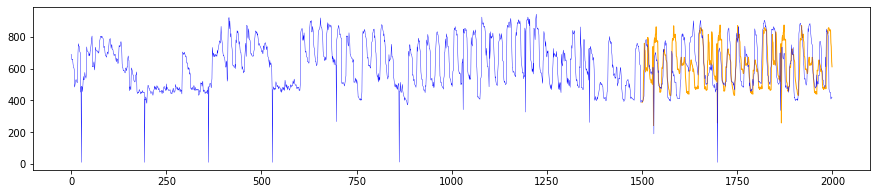

In [146]:
plt.rc('figure',figsize=(18,4))

kws = kw_series[0:2000].reset_index().drop(columns='timestamp')

stlf_res = stlf.fit()

forecast = stlf_res.forecast(500)

fig, ax = plt.subplots(plots, 1, figsize=(15,plots * 3), squeeze=False)
cnt = 0
ax[cnt,0].plot(forecast, color='orange', lw=1)
ax[cnt,0].plot(kws, color='blue', lw=0.4)

#plt.plot(kw_series.values[0:1200])
#plt.plot(forecast)
#plt.show()

In [147]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 1500
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7714.264
Date:                Tue, 13 Oct 2020   AIC                          15438.529
Time:                        13:34:24   BIC                          15465.095
Sample:                             0   HQIC                         15448.426
                               - 1500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        626.5652     17.047     36.755      0.000     593.154     659.977
ar.L1          1.3690      0.158      8.651      0.000       1.059       1.679
ar.L2         -0.3980      0.146     -2.724      0.0

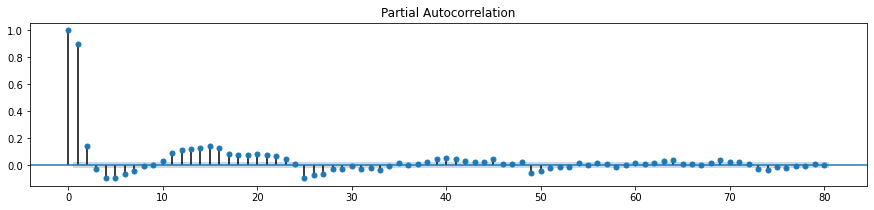

In [52]:
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(15,plots * 3), squeeze=False)
cnt = 0
#x = sm.graphics.tsa.plot_acf(df_input['KW'].values, lags=80, ax=ax[cnt,0])
#cnt = 1
x = sm.api.graphics.tsa.plot_pacf(df_input['KW'].values, lags=80, ax=ax[cnt,0])
#sm.graphics.tsa.plot_acf(df_input['KW'].values.squeeze(), lags=60)

In [131]:
arma_kw = sm.tsa.arima_model.ARIMA(df_input['KW'], order=(2, 0, 0)).fit()


In [139]:
print(arma_kw.params, '\nAIC: ', arma_kw.aic, '\nBIC: ', arma_kw.bic)

const       587.684518
ar.L1.KW      0.774405
ar.L2.KW      0.137836
dtype: float64 
AIC:  93802.84599138913 
BIC:  93830.9593464451


In [153]:
sm.tsa.stats.normaltest(resid)

AttributeError: module 'statsmodels.tsa' has no attribute 'stats'

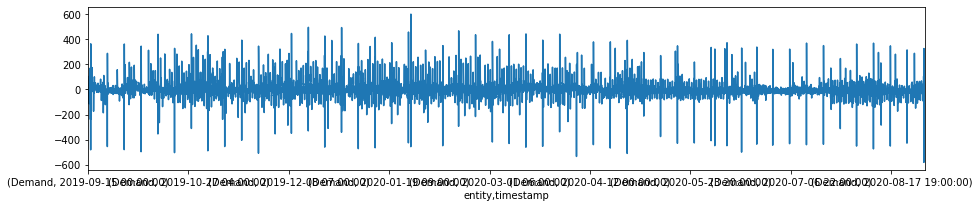

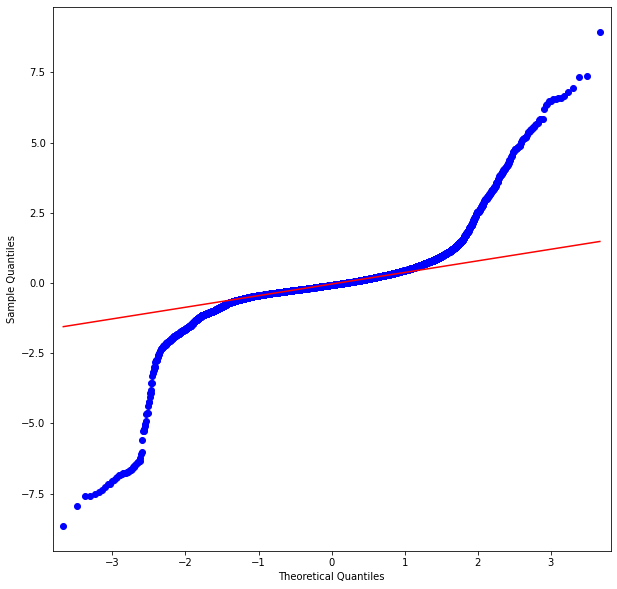

In [154]:
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(15,plots * 3), squeeze=False)
cnt = 0
x = arma_kw.resid.plot(ax=ax[cnt,0])

fig, ax = plt.subplots(1, 1, figsize=(10,10), squeeze=False)
cnt = 0
x = sm.graphics.gofplots.qqplot(arma_kw.resid, line='q', ax=ax[cnt, 0], fit=True)

In [67]:

df_demand = df_i[df_i['entity']=='Demand']


df_demand.set_index('timestamp', inplace=True)
df_demand


,entity,salesforceName,siteName,energySource,Real Demand (kW),value
timestamp,,,,,,
2019-09-15 00:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,690.480000,690.480000
2019-09-15 00:15:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,682.080000,682.080000
2019-09-15 00:30:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,687.120000,687.120000
2019-09-15 00:45:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,688.800000,688.800000
2019-09-15 01:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,685.440000,685.440000
...,...,...,...,...,...,...
2020-09-15 22:45:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,490.559998,490.559998
2020-09-15 23:00:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,480.480011,480.480011
2020-09-15 23:15:00+00:00,Demand,BRAEH1357,Jaguare,ELECTRICITY,480.480011,480.480011


In [68]:
'''
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,6), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_demand.index, df_demand['Real Demand (kW)'],linewidth=0.5,color='blue',label='Demand')
#ax[cnt,0].plot(df_i.index, df_i['MaxTemp'],linewidth=0.5,color='green',label='MaxTemp')
#ax[cnt,0].plot(df_i.index, df_i['predicted_MaxTemp'],linewidth=0.5,color='red',label='MaxTemp pred')
#ax[cnt,0].fill_between(df_i.index, df_i['predicted_MaxTemp'] - df_i['stddev_MaxTemp'],
#                df_i['predicted_MaxTemp'] + df_i['stddev_MaxTemp'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('BP real demand',fontsize=12,weight="bold")
cnt = 1
'''

'\nplots = 1\n\nfig, ax = plt.subplots(plots, 1, figsize=(20,6), squeeze=False)\ncnt = 0\nax[cnt,0].plot(df_demand.index, df_demand[\'Real Demand (kW)\'],linewidth=0.5,color=\'blue\',label=\'Demand\')\n#ax[cnt,0].plot(df_i.index, df_i[\'MaxTemp\'],linewidth=0.5,color=\'green\',label=\'MaxTemp\')\n#ax[cnt,0].plot(df_i.index, df_i[\'predicted_MaxTemp\'],linewidth=0.5,color=\'red\',label=\'MaxTemp pred\')\n#ax[cnt,0].fill_between(df_i.index, df_i[\'predicted_MaxTemp\'] - df_i[\'stddev_MaxTemp\'],\n#                df_i[\'predicted_MaxTemp\'] + df_i[\'stddev_MaxTemp\'], color="pink", alpha=0.3, label="predict stddev")\nax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))\nax[cnt,0].set_ylabel(\'BP real demand\',fontsize=12,weight="bold")\ncnt = 1\n'

In [69]:
df_daily = df_demand.groupby(pd.Grouper(freq='1D')).sum()
df_daily['value'] /= 4
df_daily.rename(columns={'value' : 'electricity-kWh'}, inplace=True)
df_daily

,Real Demand (kW),electricity-kWh
timestamp,,
2019-09-15 00:00:00+00:00,59233.440000,14808.360000
2019-09-16 00:00:00+00:00,37418.640000,9354.660000
2019-09-17 00:00:00+00:00,66097.920000,16524.480000
2019-09-18 00:00:00+00:00,72258.480000,18064.620000
2019-09-19 00:00:00+00:00,65078.160000,16269.540000
...,...,...
2020-09-11 00:00:00+00:00,59723.999926,14930.999982
2020-09-12 00:00:00+00:00,64567.439990,16141.859997
2020-09-13 00:00:00+00:00,63122.640122,15780.660030


#### see cs109 energy consumption prediction

https://cs109-energy.github.io/building-energy-consumption-prediction.html

In [71]:
def addDailyTimeFeatures(df):
    df['weekday'] = df.index.weekday
    df['day'] = df.index.dayofyear
    df['week'] = df.index.weekofyear
    df['month'] = df.index.month
    if 'hour' in df.index:
        df['hour'] = df.index.hour
    return df
    
dailyElectricityWithFeatures = addDailyTimeFeatures(df_daily)
df_demand_ = addDailyTimeFeatures(df_demand)
#print(dailyElectricityWithFeatures['electricity-kWh'].values)

sscal = preprocessing.StandardScaler()
sscald = preprocessing.StandardScaler()

dailyElectricityWithFeatures['consume'] = sscald.fit_transform(
    dailyElectricityWithFeatures['electricity-kWh'].values.reshape(-1, 1)).flatten()

df_demand_features['consume'] = sscal.fit_transform(
    df_demand_['value'].values.reshape(-1, 1)).flatten()

listFeatures = ['weekday', 'day', 'week', 'consume']
#df = dailyElectricityWithFeatures[['weekday', 'day', 'week', 'electricity-kWh']]
df = dailyElectricityWithFeatures[listFeatures]

#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2019-01':'2019-12']
testSet = df['2020-01':'2020-03']

#normalizer = np.max(trainSet)
#trainSet = trainSet / normalizer
#testSet = testSet / normalizer
#trainX_dailyElectricity = trainSet.reset_index().index.to_numpy().reshape(-1, 1)
trainX_dailyElectricity = trainSet.values[:,0:-1]
trainY_dailyElectricity = trainSet.values[:,len(listFeatures)-1]

#testX_dailyElectricity = testSet.reset_index().index.to_numpy().reshape(-1, 1)
testX_dailyElectricity = testSet.values[:,0:-1]
testY_dailyElectricity = testSet.values[:,len(listFeatures)-1]



<ipython-input-71-a68c043e79ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df.index.weekday
<ipython-input-71-a68c043e79ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.dayofyear
<ipython-input-71-a68c043e79ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


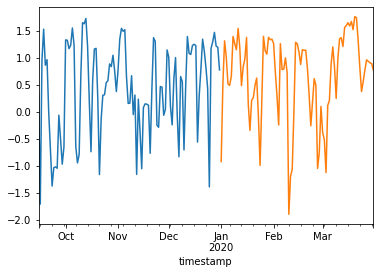

In [72]:
trainSet['consume'].plot()
testSet['consume'].plot()
#trainX_dailyElectricity

In [73]:
df_demand_features.columns

Index(['entity', 'salesforceName', 'siteName', 'energySource',
       'Real Demand (kW)', 'value', 'weekday', 'day', 'week', 'hour',
       'consume', 'month'],
      dtype='object')

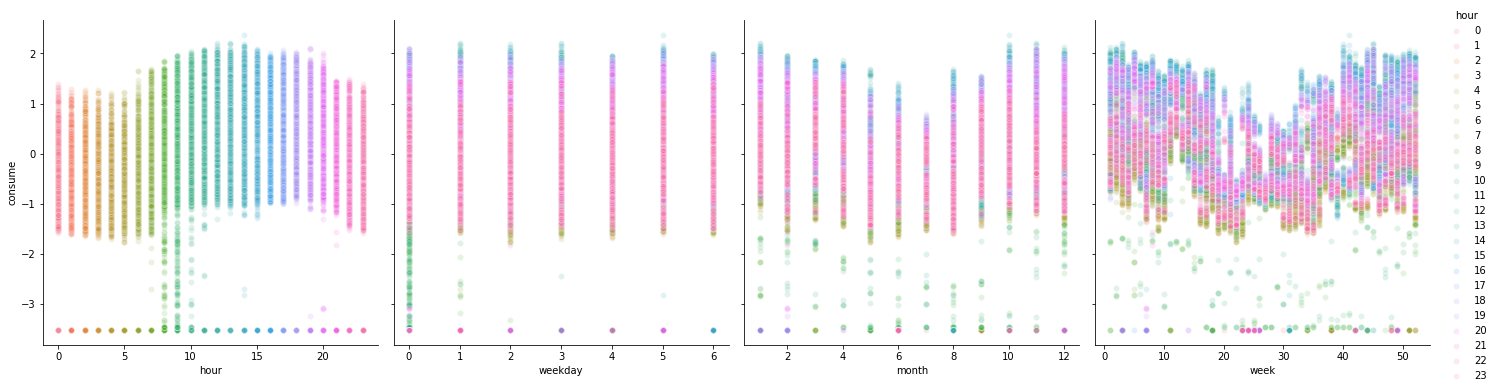

In [81]:
sns.pairplot(df_demand_features.dropna(), hue='hour', x_vars=['hour', 'weekday', 'month', 'week'],
             y_vars='consume', height=5, plot_kws={'alpha':0.15,'linewidth':1})

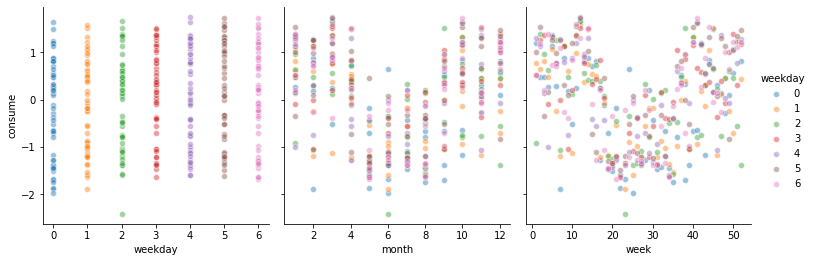

In [86]:
sns.pairplot(dailyElectricityWithFeatures.dropna(), hue='weekday', x_vars=['weekday', 'month', 'week'],
             y_vars='consume', height=3.5, plot_kws={'alpha':0.45,'linewidth':1}, kind='scatter')

-151.28569810802264
[ 5.77550613e-03  6.95769306e+00  0.00000000e+00  0.00000000e+00
 -4.96603668e+00  5.12993063e-01 -4.76920802e+00 -2.10572638e+03
  2.49865665e+01  5.20059689e+00 -1.75689916e+01  7.70933474e+00
 -2.55557194e-04]
-151.28569810802264


Text(0.5, 1.0, 'Gaussian process with Rational Quadratic (stationary) and ExpSine (seasonal)')

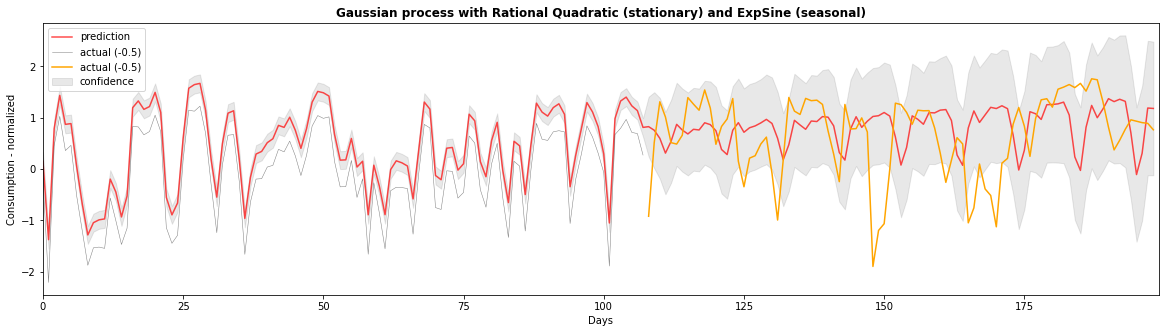

In [88]:
import george
george.__version__

from george import kernels
from sklearn.preprocessing import StandardScaler

y = trainSet['consume'].values

x = np.arange(0, y.size)
x_pred = np.arange(0, y.size + testY_dailyElectricity.size)

# Trend
trend_amplitude = 0 # !!!!
trend_length_scale = 1
k1 = trend_amplitude **2 * kernels.ExpSquaredKernel(metric=trend_length_scale**2)

# Seasonality - 12 months
magnitude = 6.7
decay_time = 365
smoothness = 1.3
k2 = magnitude**2 * kernels.ExpSquaredKernel(decay_time**2) * \
        kernels.ExpSine2Kernel(gamma=2/smoothness**2, log_period=0.1)

qmagnitude = 0.66
qshape = 0.78
qlength = 1.2
k3 = qmagnitude**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(qshape), metric=qlength**2)

noise_level = 0.2
noise_length = 0.2
k4 = noise_level**2 * kernels.ExpSquaredKernel(noise_length**2)
kernel = k1 + k2 + k3 + k4



gp = george.GP(kernel)

gp = george.GP(kernel, mean=np.mean(y), fit_mean=True,
               white_noise=np.log(0.19**2), fit_white_noise=True)

gp.compute(x ) #, yerr)

gp.get_parameter_vector()
print(gp.log_likelihood(y))
print(gp.grad_log_likelihood(y))

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)


# Run the optimization routine.
#p0 = gp.get_parameter_vector()
#results = sp.optimize.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
#gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))


pred, pred_var = gp.predict(y, x_pred, return_var=True)
#print(pred_var)




#print (pred, pred_var)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.09,
                      label='confidence')
ax[cnt,0].plot(x_pred, pred, "-", lw=1.5, alpha=0.7, color = 'red', label='prediction')
ax[cnt,0].plot(x, y-0.5, "k", lw=0.5, alpha=0.5, label='actual (-0.5)')
ax[cnt,0].plot(np.arange(y.size, y.size + testY_dailyElectricity.size), testY_dailyElectricity, 
               color='orange', label='actual (-0.5)')
#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x_pred, np.sin(x_pred), "-g")
ax[cnt,0].set_xlim(0, x_pred.size / 1.0)
#plt.ylim(-1.45, 1.45)
ax[cnt,0].set_xlabel('Days')
ax[cnt,0].set_ylabel('Consumption - normalized')
ax[cnt,0].legend()
ax[cnt,0].set_title('Gaussian process with Rational Quadratic (stationary) and ExpSine (seasonal)', 
                    fontweight='bold')


/home/markus/.local/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


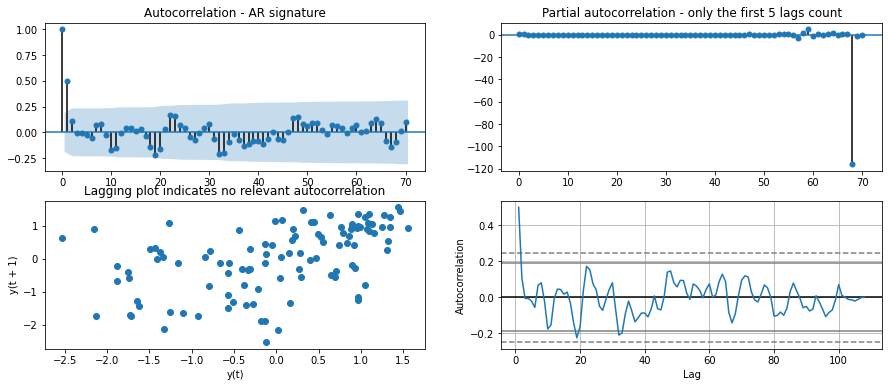

In [19]:
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 6), squeeze=False)
plot_acf(y.tolist(), lags=70, alpha=.05, ax=ax[0,0], title='Autocorrelation - AR signature')
plot_pacf(y.tolist(), lags=70, alpha=.05, ax=ax[0,1], title='Partial autocorrelation - only the first 5 lags count')

df_dat = pd.DataFrame(y)

pd.plotting.lag_plot(df_dat, ax=ax[1,0], lag=1)

ax[1,0].set_title('Lagging plot indicates no relevant autocorrelation')

pd.plotting.autocorrelation_plot(df_dat, ax=ax[1,1])


In [99]:
ARIMA51model = ARIMA(y, order=(2,1 ,1))
model_fit = ARIMA51model.fit(disp=0)
print(model_fit.summary())

print(df_dat.shape, model_fit.resid.shape)

df_dat['residuals'] = np.insert(model_fit.resid, 1, 0)

df_dat['res_anom'] = np.insert(abs(model_fit.resid), 1, 0)

df_dat['arimapred'] = np.append(model_fit.predict(), 0)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -117.201
Method:                       css-mle   S.D. of innovations              0.710
Date:                Tue, 06 Oct 2020   AIC                            244.402
Time:                        09:54:13   BIC                            257.766
Sample:                             1   HQIC                           249.820
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.365      0.172      -0.002       0.012
ar.L1.D.y      0.5866      0.096      6.141      0.000       0.399       0.774
ar.L2.D.y     -0.2018      0.098     -2.068      0.0

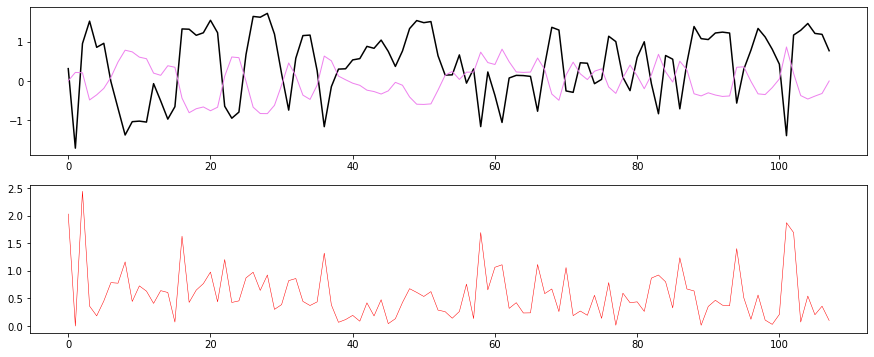

In [100]:
plots=1
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 6), squeeze=False)
ax[0,0].plot(x, y, color='black', label='temperature')
ax[0,0].plot(x, df_dat['arimapred'], lw=1, color='violet', label='forecast')

ax[1,0].plot(x, abs(df_dat['residuals']), lw=0.5, color='red', label='residual error')
#ax[0].scatter(df_inputm2.index, df_inputm2['res_anom']+4, lw=4, color='red')

In [ ]:
model.model.state_dict

In [127]:
p_ = gp.get_parameter_vector()
p_[0] = -10e8
gp.set_parameter_vector(p_)
print (p_)

[-1.00000000e+09  0.00000000e+00  2.61666564e+00  9.21034037e+00
  1.18343195e+00  1.00000000e-01 -8.31030888e-01 -2.48461359e-01
  3.64643114e-01 -3.21887582e+00 -3.21887582e+00]


In [128]:
import emcee


def lnprob(p):
    # Trivial uniform prior.
    if np.any((-1000 > p[1:]) + (p[1:] > 1000)):
        return -np.inf

    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.lnlikelihood(y, quiet=True)


#gp.compute(t)

# Set up the sampler.
nwalkers, ndim = 36, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 200)

print("Running production chain")
sampler.run_mcmc(p0, 200);

Running burn-in
Running production chain


In [129]:
gp.get_parameter_vector() 

array([-1.00000027e+09, -1.57676791e+02,  1.61800740e+00, -3.64806347e+02,
        3.09293157e+01,  1.19201590e+01, -6.61986464e+00,  2.27795453e+01,
        1.30313342e+01, -1.17684708e+02,  1.95019112e+02])

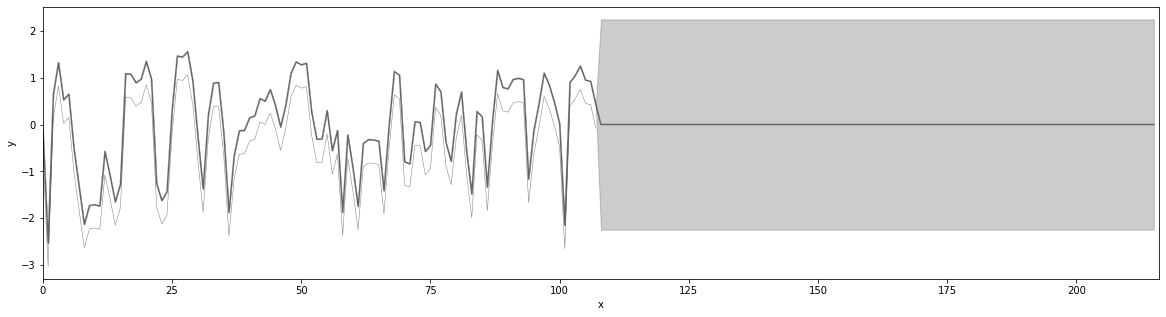

In [130]:

pred, pred_var = gp.predict(y, x_pred, return_var=True)
#print(pred_var)


#print (pred, pred_var)
plots = 1
fig, ax = plt.subplots(plots, 1, figsize=(20,5), squeeze=False)
cnt = 0
ax[cnt,0].fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
ax[cnt,0].plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
ax[cnt,0].plot(x, y-0.5, "k", lw=0.5, alpha=0.5)
#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x_pred, np.sin(x_pred), "-g")
plt.xlim(0, x_pred.size)
#plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");

In [116]:
print (gp.get_parameter_vector())

[       -inf  0.          2.61666564  9.21034037  1.18343195  0.1
 -0.83103089 -0.24846136  0.36464311 -3.21887582 -3.21887582]


In [29]:
import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared, WhiteKernel
from sklearn import model_selection



(91, 5) (91,) 0.0 0.0
Train score R2: 0.9787569528599943
Test score R2: -58.2047104779399


/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/markus/.local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


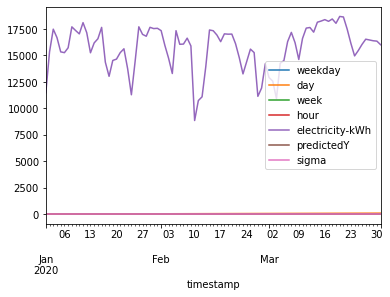

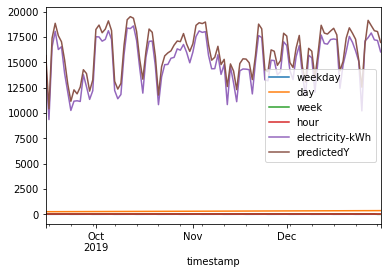

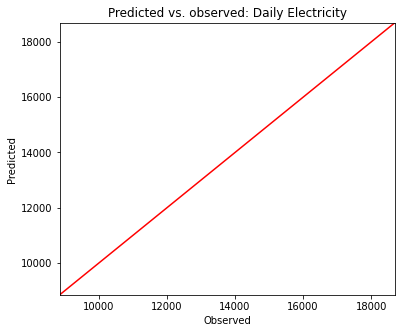

In [44]:

#kernel = gaussian_process.kernels.RBF(length_scale=0.2)
#            gaussian_process.kernels.ConstantKernel(1.0) #* 

#kernel = gaussian_process.kernels.ExpSineSquared(length_scale=0.1, periodicity=0.1)
#kernel = gaussian_process.kernels.RationalQuadratic(length_scale=0.5, alpha=0.5)
#kernel = gaussian_process.kernels.ConstantKernel(1.0) * gaussian_process.kernels.ExpSineSquared(length_scale=0.1, periodicity=0.1)

#kernel = ConstantKernel(0.1, (1e-23, 1e5)) * RBF(length_scale=0.2) + WhiteKernel(0.1, (1e-23, 1e5))

kernel = RBF(length_scale=2)


gp = gaussian_process.GaussianProcessRegressor(alpha = 10e-3, kernel=kernel, n_restarts_optimizer=10)

gp.fit(trainX_dailyElectricity, trainY_dailyElectricity)


predictedY, stddev = gp.predict(testX_dailyElectricity, return_std=True)
oldY  = gp.predict(trainX_dailyElectricity)

results = testSet.copy()
print(results.shape, predictedY.shape, min(predictedY), max(predictedY))
results['predictedY'] = predictedY
results['sigma'] = np.sqrt(stddev)
resTrain = trainSet.copy()
resTrain['predictedY'] = oldY + 1000

print("Train score R2:", gp.score(trainX_dailyElectricity, trainY_dailyElectricity))
print("Test score R2:", sklearn.metrics.r2_score(testY_dailyElectricity, predictedY))


results.plot()
resTrain.plot()

plt.figure(figsize = (6,5))
plt.scatter(testY_dailyElectricity, predictedY)
plt.plot([min(testY_dailyElectricity), max(testY_dailyElectricity)],
         [min(testY_dailyElectricity), max(testY_dailyElectricity)], 'r')
plt.xlim([min(testY_dailyElectricity), max(testY_dailyElectricity)])
plt.ylim([min(testY_dailyElectricity), max(testY_dailyElectricity)])
plt.title('Predicted vs. observed: Daily Electricity')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()
    

In [45]:
gp.kernel_.get_params()

{'length_scale': 2.130867815417103, 'length_scale_bounds': (1e-05, 100000.0)}

In [87]:
scores

array([[-0.06771299, -0.47237881, -0.69534534, -1.98642615, -0.20126418,
        -0.39702647, -2.08314569, -3.14383665, -1.62342265, -0.47315791],
       [-0.06771299, -0.47237881, -0.69534534, -1.98642615, -0.20126418,
        -0.39702647, -2.0831457 , -3.14383665, -1.62342265, -0.47315791]])

In [8]:
df_i.index.get_level_values(0).unique()

Index(['Demand', 'RACK 01 Cold Active Compressors Power %',
       'RACK 01 Cold Active Fans Power %',
       'RACK 01 Cold Condensing Calculated Setpoint',
       'RACK 01 Cold Condensing Mode', 'RACK 01 Cold Condensing Setpoint',
       'RACK 01 Cold Condensing Temperature',
       'RACK 01 Cold Maximum Condensing Setpoint',
       'RACK 01 Cold Minimum Condensing Setpoint',
       'RACK 01 Cold Offset Floating Condensing',
       ...
       'LIGHT 01 Circuit 2 Output Complement', 'LIGHT 01 Circuit 2 Status',
       'LIGHT 02 Circuit 1 Output', 'LIGHT 02 Circuit 1 Status',
       'LIGHT 02 Circuit 2 Output', 'LIGHT 02 Circuit 2 Status',
       'LIGHT 03 Circuit 1 Output', 'LIGHT 03 Circuit 1 Status',
       'LIGHT 03 Circuit 2 Output', 'LIGHT 03 Circuit 2 Status'],
      dtype='object', name='entity', length=141)

In [6]:
df_demand.reset_index(inplace=True)
from autoviz.AutoViz_Class import AutoViz_Class

Imported AutoViz_Class version: 0.0.68. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [7]:
AV = AutoViz_Class()
dft = AV.AutoViz(filename='', dfte=df_demand, verbose=1)

Shape of your Data Set: (35232, 6)
Classifying variables in data set...
('index', 'occurred at index 0')
Not able to read or load file. Please check your inputs and try again...
